In [1]:
import time
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

from torchsummary import summary

In [12]:
batch_size = 16

data_transforms = {
    'train':
        transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val':
        transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

train = torchvision.datasets.CIFAR10(root='./data',
                                     train=True,
                                     download=True,
                                     transform=data_transforms['train'])
test = torchvision.datasets.CIFAR10(root='./data',
                                    train=False,
                                    download=True,
                                    transform=data_transforms['val'])

train_data_loader = torch.utils.data.DataLoader(train, batch_size)
test_data_loader = torch.utils.data.DataLoader(test, batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 32, 32]) torch.Size([16])
tensor(8)


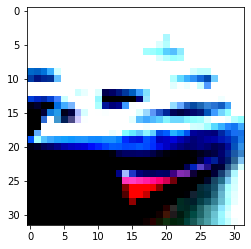

In [13]:
import matplotlib.pyplot as plt

for X, y in test_data_loader:
    print(X.size(), y.size())
    print(y[1])
    plt.imshow(  X[1].permute(1, 2, 0))
    break

# LeNet5

In [36]:
lenet = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=3), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=3), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(576, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10), nn.Sigmoid()
)

In [35]:
summary(lenet, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             168
           Sigmoid-2            [-1, 6, 30, 30]               0
         AvgPool2d-3            [-1, 6, 15, 15]               0
            Conv2d-4           [-1, 16, 13, 13]             880
           Sigmoid-5           [-1, 16, 13, 13]               0
         AvgPool2d-6             [-1, 16, 6, 6]               0
           Flatten-7                  [-1, 576]               0
            Linear-8                  [-1, 120]          69,240
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
          Sigmoid-13                   [-1, 10]               0
Total params: 81,302
Trainable params: 

In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if phase == 'train':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'New best accuracy: {best_acc}. The best model was updated.')
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [37]:
opt_lenet = optim.Adam(lenet.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet, lenet_hist = train_model(model=lenet,
                          dataloaders={'train':train_data_loader, 'val':test_data_loader},
                          criterion=criterion,
                          optimizer=opt_lenet,
                          num_epochs=20)

Epoch 0/19
----------
train Loss: 2.0635 Acc: 0.3097
val Loss: 2.0836 Acc: 0.0980
New best accuracy: 0.098. The best model was updated.

Epoch 1/19
----------
train Loss: 1.9554 Acc: 0.3864
val Loss: 2.0365 Acc: 0.0942

Epoch 2/19
----------
train Loss: 1.9247 Acc: 0.4124
val Loss: 2.0556 Acc: 0.0921

Epoch 3/19
----------
train Loss: 1.9085 Acc: 0.4300
val Loss: 2.1063 Acc: 0.0953

Epoch 4/19
----------
train Loss: 1.8939 Acc: 0.4461
val Loss: 1.9851 Acc: 0.0969

Epoch 5/19
----------
train Loss: 1.8831 Acc: 0.4534
val Loss: 2.0042 Acc: 0.0955

Epoch 6/19
----------
train Loss: 1.8724 Acc: 0.4706
val Loss: 1.9420 Acc: 0.0986
New best accuracy: 0.0986. The best model was updated.

Epoch 7/19
----------
train Loss: 1.8633 Acc: 0.4786
val Loss: 2.0333 Acc: 0.0979

Epoch 8/19
----------
train Loss: 1.8535 Acc: 0.4898
val Loss: 1.9736 Acc: 0.0970

Epoch 9/19
----------
train Loss: 1.8467 Acc: 0.4959
val Loss: 1.9627 Acc: 0.0993
New best accuracy: 0.0993. The best model was updated.

Epoch 

In [16]:
opt_lenet = optim.Adam(lenet.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet, lenet_hist = train_model(model=lenet,
                          dataloaders={'train':train_data_loader, 'val':test_data_loader},
                          criterion=criterion,
                          optimizer=opt_lenet,
                          num_epochs=20)

Epoch 0/19
----------
train Loss: 2.1596 Acc: 0.1900
val Loss: 2.1462 Acc: 0.0981
New best accuracy: 0.0981. The best model was updated.

Epoch 1/19
----------
train Loss: 2.0609 Acc: 0.2462
val Loss: 2.1172 Acc: 0.1028
New best accuracy: 0.1028. The best model was updated.

Epoch 2/19
----------
train Loss: 2.0066 Acc: 0.3039
val Loss: 2.1510 Acc: 0.0980

Epoch 3/19
----------
train Loss: 1.9673 Acc: 0.3481
val Loss: 2.0576 Acc: 0.1010

Epoch 4/19
----------
train Loss: 1.9430 Acc: 0.3703
val Loss: 2.0744 Acc: 0.0966

Epoch 5/19
----------
train Loss: 1.9299 Acc: 0.3869
val Loss: 2.0303 Acc: 0.0985

Epoch 6/19
----------
train Loss: 1.9186 Acc: 0.3985
val Loss: 2.0380 Acc: 0.0967

Epoch 7/19
----------
train Loss: 1.9089 Acc: 0.4122
val Loss: 1.9998 Acc: 0.0990

Epoch 8/19
----------
train Loss: 1.9006 Acc: 0.4214
val Loss: 1.9475 Acc: 0.0968

Epoch 9/19
----------
train Loss: 1.8945 Acc: 0.4295
val Loss: 1.9658 Acc: 0.0959

Epoch 10/19
----------
train Loss: 1.8866 Acc: 0.4388
val Lo

# Fine-tuning

In [58]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
            
def initialize_resnet18(num_classes, use_pretrained=True, frz=True):
    """ Resnet18
    """
    resnet = models.resnet18(pretrained=use_pretrained)
    if frz:
        freeze(resnet)
    num_ftrs = resnet.fc.in_features
    resnet.fc = nn.Linear(num_ftrs, num_classes)

    return resnet

# Initialize the model for this run
resnet = initialize_resnet18(num_classes=10, use_pretrained=True)
resnet_uf = initialize_resnet18(num_classes=10, use_pretrained=True, frz=False)

for param in resnet.parameters():
    print(param.requires_grad)
    
for param in resnet_uf.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [10]:
summary(resnet, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [59]:
opt_resnet = optim.Adam(resnet_uf.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet, hist_resnet = train_model(model=resnet_uf,
                                  dataloaders={'train': train_data_loader,
                                               'val': test_data_loader},
                                  criterion=criterion,
                                  optimizer=opt_resnet,
                                  num_epochs=20)

Epoch 0/19
----------
train Loss: 1.6294 Acc: 0.4157
val Loss: 1.7829 Acc: 0.0977
New best accuracy: 0.0977. The best model was updated.

Epoch 1/19
----------
train Loss: 1.3918 Acc: 0.5031
val Loss: 2.0912 Acc: 0.0983
New best accuracy: 0.0983. The best model was updated.

Epoch 2/19
----------
train Loss: 1.1689 Acc: 0.5881
val Loss: 1.5312 Acc: 0.0983

Epoch 3/19
----------
train Loss: 1.1228 Acc: 0.6068
val Loss: 1.5046 Acc: 0.0968

Epoch 4/19
----------
train Loss: 0.9958 Acc: 0.6529
val Loss: 1.8307 Acc: 0.1000
New best accuracy: 0.1. The best model was updated.

Epoch 5/19
----------
train Loss: 0.9095 Acc: 0.6831
val Loss: 1.7800 Acc: 0.1052
New best accuracy: 0.1052. The best model was updated.

Epoch 6/19
----------
train Loss: 0.8500 Acc: 0.7055
val Loss: 1.6856 Acc: 0.0985

Epoch 7/19
----------
train Loss: 0.7920 Acc: 0.7247
val Loss: 1.7264 Acc: 0.0968

Epoch 8/19
----------
train Loss: 0.7366 Acc: 0.7455
val Loss: 1.9036 Acc: 0.0991

Epoch 9/19
----------
train Loss: 0.

In [18]:
opt_resnet = optim.Adam(resnet.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet, hist_resnet = train_model(model=resnet,
                                  dataloaders={'train': train_data_loader,
                                               'val': test_data_loader},
                                  criterion=criterion,
                                  optimizer=opt_resnet,
                                  num_epochs=20)

Epoch 0/19
----------
train Loss: 1.8389 Acc: 0.3535
val Loss: 1.9592 Acc: 0.0959
New best accuracy: 0.0959. The best model was updated.

Epoch 1/19
----------
train Loss: 1.7868 Acc: 0.3743
val Loss: 1.8519 Acc: 0.0955

Epoch 2/19
----------
train Loss: 1.7843 Acc: 0.3758
val Loss: 2.3095 Acc: 0.0986
New best accuracy: 0.0986. The best model was updated.

Epoch 3/19
----------
train Loss: 1.7832 Acc: 0.3740
val Loss: 1.7865 Acc: 0.0997
New best accuracy: 0.0997. The best model was updated.

Epoch 4/19
----------
train Loss: 1.7793 Acc: 0.3783
val Loss: 2.0731 Acc: 0.1011
New best accuracy: 0.1011. The best model was updated.

Epoch 5/19
----------
train Loss: 1.7756 Acc: 0.3834
val Loss: 2.2047 Acc: 0.1008

Epoch 6/19
----------
train Loss: 1.7817 Acc: 0.3761
val Loss: 1.9103 Acc: 0.0943

Epoch 7/19
----------
train Loss: 1.7810 Acc: 0.3754
val Loss: 1.9920 Acc: 0.0965

Epoch 8/19
----------
train Loss: 1.7790 Acc: 0.3804
val Loss: 2.3887 Acc: 0.1000

Epoch 9/19
----------
train Loss:

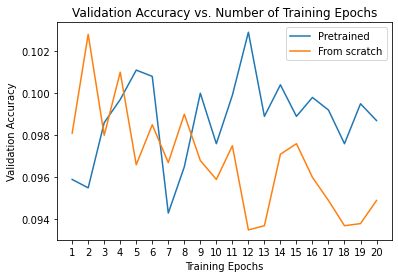

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,20+1),hist_resnet,label="Pretrained")
plt.plot(range(1,20+1),lenet_hist,label="From scratch")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, 20+1, 1.0))
plt.legend()
plt.show()

# Filters & Feature Maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

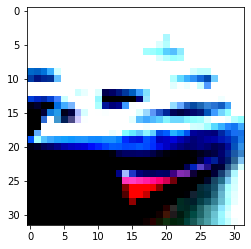

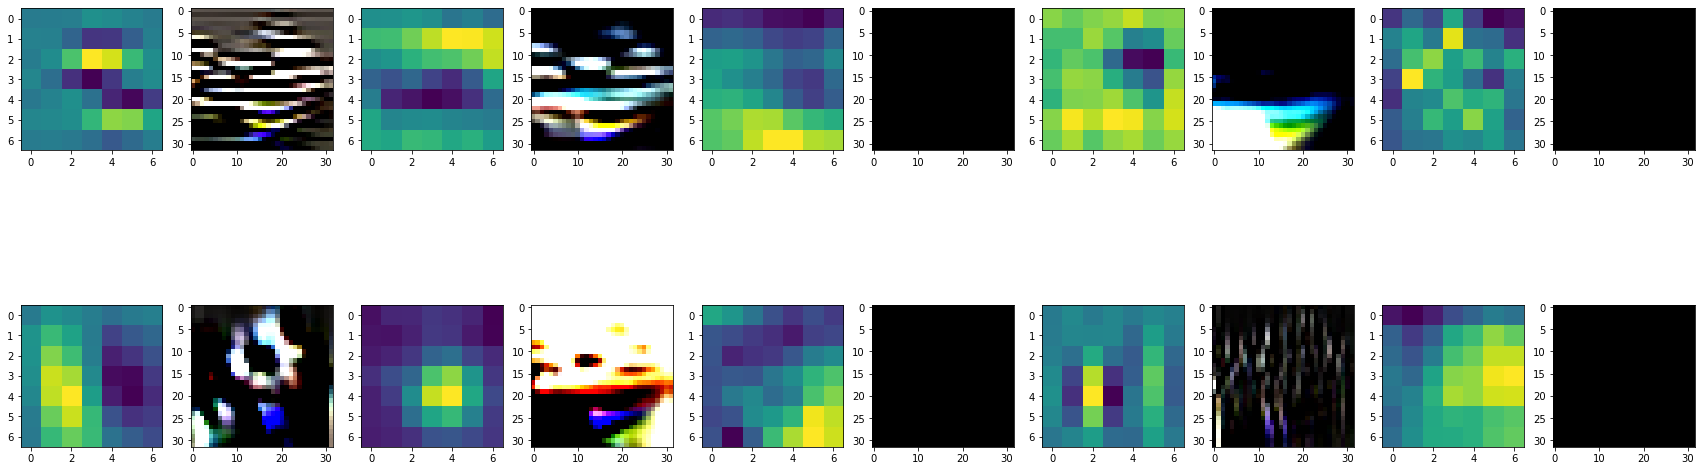

In [31]:
import cv2
from PIL import Image

resnet.eval()

# load one batch of testing images
dataiter = iter(test_data_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 1
img = np.squeeze(images[idx])
# print(img.shape)

img = np.moveaxis(img, 0, -1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# use OpenCV's filter2D function
# apply a specific set of filter weights (like the one's displayed above) to the test image
# print(img.shape)
plt.imshow(np.asarray(img))

# first conv layer - for 10 filters
weights = resnet.conv1.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
plt.show()

In [49]:
next(lenet.parameters())

Parameter containing:
tensor([[[[ 2.2710e-01,  1.3149e-01, -1.7514e-01],
          [ 3.8821e-01,  4.8267e-03, -2.5219e-01],
          [ 1.5749e-01, -2.0036e-01, -1.5894e-01]],

         [[ 2.8687e-01, -9.4757e-02, -7.2498e-02],
          [ 3.4325e-01, -5.0313e-02, -2.1558e-01],
          [ 2.2574e-01, -2.6375e-01, -3.8174e-01]],

         [[ 3.3070e-02, -1.6175e-01, -1.8023e-01],
          [ 3.0409e-01,  1.9368e-02, -9.0824e-02],
          [ 2.6262e-01, -4.0100e-02, -4.0628e-01]]],


        [[[ 2.1088e-02,  8.5203e-02, -1.8859e-01],
          [ 3.0183e-02,  1.8547e-02, -1.4922e-01],
          [ 3.8790e-01,  3.1135e-01,  2.2632e-01]],

         [[ 7.2623e-03, -3.1739e-01, -4.1152e-01],
          [ 6.4989e-04, -2.8782e-01, -4.1592e-01],
          [ 3.6523e-01,  2.8670e-01, -1.2928e-01]],

         [[-4.9469e-02, -1.7579e-01,  1.0178e-01],
          [-2.0238e-01,  4.9161e-02, -1.0988e-01],
          [ 1.1422e-01,  8.0558e-02,  1.5849e-01]]],


        [[[ 5.4617e-01,  4.1884e-01,  8.7504

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


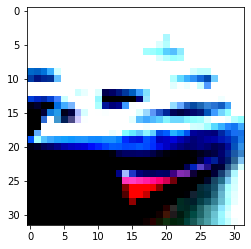

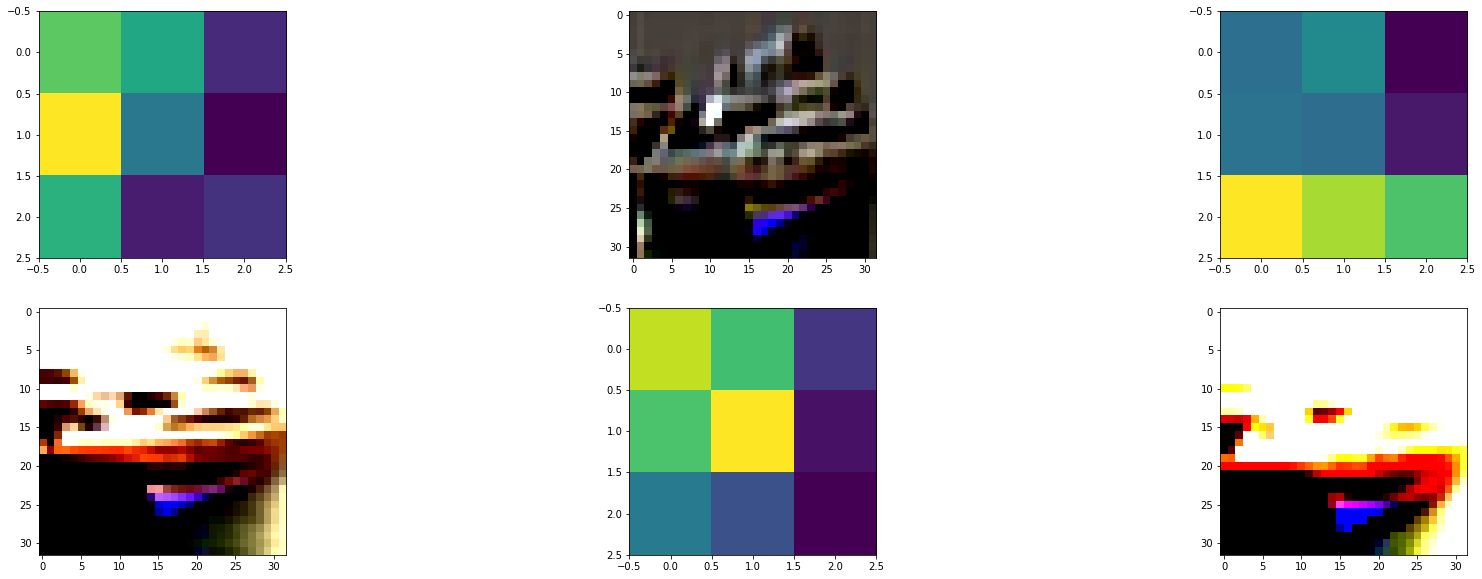

In [54]:
lenet.eval()

# load one batch of testing images
dataiter = iter(test_data_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 1
img = np.squeeze(images[idx])
# print(img.shape)

img = np.moveaxis(img, 0, -1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# use OpenCV's filter2D function
# apply a specific set of filter weights (like the one's displayed above) to the test image
# print(img.shape)
plt.imshow(np.asarray(img))

# first conv layer - for 10 filters
w = next(lenet.parameters())
w = weights.detach().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 3
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
plt.show()